# Import the dataset as spark dataframe

In [1]:
data_path = "/home/jovyan/shared/David/gdelt_study_data/20250106/part-00000-44b31ecc-d942-4aaf-a6cd-172c5ad7b04d-c000.csv"
# shared/David/gdelt_study_data/20250106/part-00000-44b31ecc-d942-4aaf-a6cd-172c5ad7b04d-c000.csv

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
from pyspark.sql import SparkSession
import pandas as pd
pd.set_option('display.max_rows', None) 


#parameter for master can be changed depending on the environment
spark = SparkSession.builder \
 .master("local") \
 .appName("GDELT-study") \
 .getOrCreate()

In [3]:
df = spark.read.csv(data_path, header=True)
df.show(2,vertical=True,truncate=False )

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------
 Cameo                 | MAKE PUBLIC STATEMENT                                                                                                                  
 Cameo_full            | Acknowledge or claim responsibility                                                                                                    
 GLOBALEVENTID         | 1218993708                                                                                                                             
 SQLDATE               | 20241230                                                                                                                               
 Actor1Name            | ISLAMIC                                                                                                                                
 Actor1Geo_FullName    | Jabalia, 

In [4]:
# 1) Select the Cameo column, drop duplicates
distinct_cameo = df.select("Cameo_full").distinct()

# 2) Show them in the console
distinct_cameo.orderBy("Cameo_full").show(truncate=False)


+----------------------------------------------------------------------+
|Cameo_full                                                            |
+----------------------------------------------------------------------+
|NULL                                                                  |
|Abduct, hijack, or take hostage                                       |
|Accede to demands for change in leadership                            |
|Accede to requests or demands for political reform not specified below|
|Accuse of aggression                                                  |
|Accuse of crime, corruption                                           |
|Accuse of war crimes                                                  |
|Accuse, not specified below                                           |
|Acknowledge or claim responsibility                                   |
|Apologize                                                             |
|Appeal for aid, not specified below               

# Add news origin country column

In [5]:
# on each node (or via your cluster’s bootstrap/init scripts):
!pip install tldextract geoip2 pycountry


In [6]:
spark.sparkContext.addFile("GeoLite2-Country.mmdb")  # Add to worker nodes

In [7]:
from pyspark.sql.functions import pandas_udf, col
from pyspark.sql.types import StringType
from pyspark import SparkFiles
import pandas as pd
import tldextract
import socket
import geoip2.database
import pycountry
from urllib.parse import urlparse
import re

@pandas_udf(StringType())
def detect_country_udf(url_series: pd.Series) -> pd.Series:
    # Get path to distributed GeoLite2 DB
    geo_db_path = SparkFiles.get("GeoLite2-Country.mmdb")
    
    # Load GeoIP database once per batch
    with geoip2.database.Reader(geo_db_path) as geo_reader:
        def _country_from_ip(url):
            try:
                ext = tldextract.extract(url)
                domain = f"{ext.domain}.{ext.suffix}"
                ip = socket.gethostbyname(domain)
                resp = geo_reader.country(ip)
                return resp.country.name
            except Exception:
                return None

        def _country_from_tld(url):
            ext = tldextract.extract(url)
            code = ext.suffix.lower().split('.')[-1]
            if len(code) == 2:
                code = 'gb' if code == 'uk' else code
                country = pycountry.countries.get(alpha_2=code.upper())
                return country.name if country else None
            return None

        def _country_from_path(url):
            path = urlparse(url).path.strip('/')
            for segment in path.split('/'):
                for token in re.split(r'[-_]', segment):
                    if token:
                        try:
                            return pycountry.countries.lookup(token).name
                        except LookupError:
                            continue
            return None

        def _detect_country(url):
            return (_country_from_ip(url) or 
                    _country_from_tld(url) or 
                    _country_from_path(url))

        return url_series.apply(_detect_country)

In [8]:
df = df.withColumn("source_country", detect_country_udf(col("SOURCEURL")))

In [9]:
df.printSchema()

root
 |-- Cameo: string (nullable = true)
 |-- Cameo_full: string (nullable = true)
 |-- GLOBALEVENTID: string (nullable = true)
 |-- SQLDATE: string (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1Geo_FullName: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2Geo_FullName: string (nullable = true)
 |-- IsRootEvent: string (nullable = true)
 |-- EventCode: string (nullable = true)
 |-- EventBaseCode: string (nullable = true)
 |-- QuadClass: string (nullable = true)
 |-- GoldsteinScale: string (nullable = true)
 |-- NumMentions: string (nullable = true)
 |-- NumSources: string (nullable = true)
 |-- NumArticles: string (nullable = true)
 |-- AvgTone: string (nullable = true)
 |-- ActionGeo_Type: string (nullable = true)
 |-- ActionGeo_FullName: string (nullable = true)
 |-- ActionGeo_CountryCode: string (nullable = true)
 |-- SOURCEURL: string (nullable = true)
 |-- source_country: string (nullable = true)



In [10]:
df.show(2,vertical=True,truncate=False )

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------
 Cameo                 | MAKE PUBLIC STATEMENT                                                                                                                  
 Cameo_full            | Acknowledge or claim responsibility                                                                                                    
 GLOBALEVENTID         | 1218993708                                                                                                                             
 SQLDATE               | 20241230                                                                                                                               
 Actor1Name            | ISLAMIC                                                                                                                                
 Actor1Geo_FullName    | Jabalia, 

In [12]:
from pyspark.sql import functions as F

df = df.withColumn("SQLDATE", F.to_date(F.col("SQLDATE"), "yyyyMMdd")) \
       .withColumn("GoldsteinScale", F.col("GoldsteinScale").cast("double")) \
       .withColumn("NumMentions", F.col("NumMentions").cast("integer")) \
       .withColumn("NumSources", F.col("NumSources").cast("integer")) \
       .withColumn("NumArticles", F.col("NumArticles").cast("integer")) \
       .withColumn("AvgTone", F.col("AvgTone").cast("double"))

In [13]:
from pyspark.sql.functions import broadcast

# 1) Define full lists of country names for each region
usa_countries = [
    "United States", "Canada", "Mexico"
]

europe_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo",
    "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova",
    "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway",
    "Poland", "Portugal", "Romania", "San Marino", "Serbia", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine", "United Kingdom",
    "Vatican City"
]

middle_east_countries = [
    "Bahrain", "Cyprus", "Egypt", "Iran", "Iraq", "Israel", "Jordan",
    "Kuwait", "Lebanon", "Oman", "Palestine", "Qatar", "Saudi Arabia",
    "Syria", "Turkey", "United Arab Emirates", "Yemen"
]

# 2) Build the mapping and turn it into a DataFrame
region_map = (
    [(c, "USA") for c in usa_countries] +
    [(c, "Europe") for c in europe_countries] +
    [(c, "Middle East") for c in middle_east_countries]
)

region_df = spark.createDataFrame(region_map, ["source_country", "region"])

# 3) (Optional) Inspect
region_df.show(truncate=False)


+----------------------+------+
|source_country        |region|
+----------------------+------+
|United States         |USA   |
|Canada                |USA   |
|Mexico                |USA   |
|Albania               |Europe|
|Andorra               |Europe|
|Armenia               |Europe|
|Austria               |Europe|
|Azerbaijan            |Europe|
|Belarus               |Europe|
|Belgium               |Europe|
|Bosnia and Herzegovina|Europe|
|Bulgaria              |Europe|
|Croatia               |Europe|
|Cyprus                |Europe|
|Czech Republic        |Europe|
|Denmark               |Europe|
|Estonia               |Europe|
|Finland               |Europe|
|France                |Europe|
|Georgia               |Europe|
+----------------------+------+
only showing top 20 rows



In [14]:
df2 = df.join(
    broadcast(region_df),
    on="source_country",
    how="inner"     # inner if you only want these 3 regions
)


In [15]:
df2.printSchema()

root
 |-- source_country: string (nullable = true)
 |-- Cameo: string (nullable = true)
 |-- Cameo_full: string (nullable = true)
 |-- GLOBALEVENTID: string (nullable = true)
 |-- SQLDATE: date (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1Geo_FullName: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2Geo_FullName: string (nullable = true)
 |-- IsRootEvent: string (nullable = true)
 |-- EventCode: string (nullable = true)
 |-- EventBaseCode: string (nullable = true)
 |-- QuadClass: string (nullable = true)
 |-- GoldsteinScale: double (nullable = true)
 |-- NumMentions: integer (nullable = true)
 |-- NumSources: integer (nullable = true)
 |-- NumArticles: integer (nullable = true)
 |-- AvgTone: double (nullable = true)
 |-- ActionGeo_Type: string (nullable = true)
 |-- ActionGeo_FullName: string (nullable = true)
 |-- ActionGeo_CountryCode: string (nullable = true)
 |-- SOURCEURL: string (nullable = true)
 |-- region: string (nullabl

In [16]:
from pyspark.sql.functions import to_date, col, avg

# 3a) If SQLDATE is still a string like "20241230", parse it:
df3 = df2.withColumn("date", to_date(col("SQLDATE"), "yyyyMMdd"))

# 3b) Aggregate
sentiment_ts = (
    df3
      .groupBy("region", "date")
      .agg(avg(col("AvgTone")).alias("avg_tone"))
      .orderBy("region", "date")
)

sentiment_ts.show()


+-----------+----------+-------------------+
|     region|      date|           avg_tone|
+-----------+----------+-------------------+
|     Europe|2024-01-07|-3.1724137931034506|
|     Europe|2024-12-07| -7.035795231466612|
|     Europe|2024-12-30| -6.710300019454641|
|     Europe|2025-01-05|-3.4041118258155527|
|     Europe|2025-01-06| -4.512458636066439|
|Middle East|2024-01-07|-2.9571550642206663|
|Middle East|2024-12-07|  -5.99053595579026|
|Middle East|2025-01-06| -5.087732596425704|
|        USA|2024-01-07| -4.069982343184167|
|        USA|2024-12-07|-3.5624496427169774|
|        USA|2024-12-30| -3.996338930387782|
|        USA|2025-01-05| -4.931338203140531|
|        USA|2025-01-06|-4.4747830742603645|
+-----------+----------+-------------------+



Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Tone')

Text(0.5, 1.0, 'Sentiment over time by region')

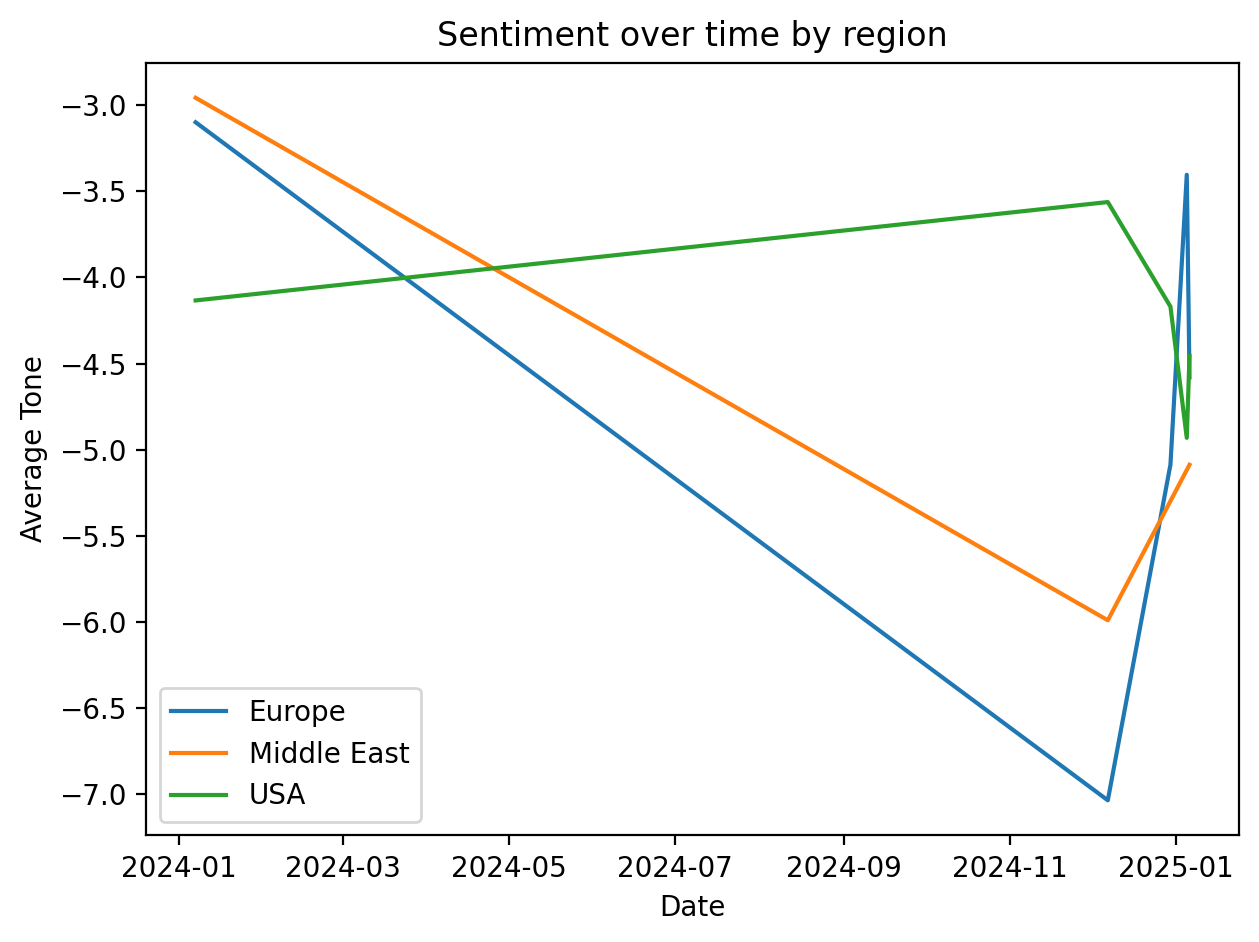

In [17]:
# Collect to Pandas
pdf = sentiment_ts.toPandas()

import matplotlib.pyplot as plt

for region in pdf.region.unique():
    sub = pdf[pdf.region == region]
    plt.plot(sub.date, sub.avg_tone, label=region)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Average Tone")
plt.title("Sentiment over time by region")
plt.tight_layout()
plt.show()


In [22]:
from pyspark.sql.functions import expr

# Map QuadClass 1–4 into human-readable categories
df_typed = df2.withColumn("event_type",
    expr("""
      CASE QuadClass
        WHEN '1' THEN 'Verbal Cooperation'
        WHEN '2' THEN 'Material Cooperation'
        WHEN '3' THEN 'Verbal Conflict'
        WHEN '4' THEN 'Material Conflict'
        ELSE 'Other'
      END
    """)
)


In [25]:
df_typed = df_typed.withColumn("polarity",
    expr("CASE WHEN GoldsteinScale > 0 THEN 'Positive' ELSE 'Negative' END")
)


In [26]:
df_typed.printSchema()

root
 |-- source_country: string (nullable = true)
 |-- Cameo: string (nullable = true)
 |-- Cameo_full: string (nullable = true)
 |-- GLOBALEVENTID: string (nullable = true)
 |-- SQLDATE: date (nullable = true)
 |-- Actor1Name: string (nullable = true)
 |-- Actor1Geo_FullName: string (nullable = true)
 |-- Actor2Name: string (nullable = true)
 |-- Actor2Geo_FullName: string (nullable = true)
 |-- IsRootEvent: string (nullable = true)
 |-- EventCode: string (nullable = true)
 |-- EventBaseCode: string (nullable = true)
 |-- QuadClass: string (nullable = true)
 |-- GoldsteinScale: double (nullable = true)
 |-- NumMentions: integer (nullable = true)
 |-- NumSources: integer (nullable = true)
 |-- NumArticles: integer (nullable = true)
 |-- AvgTone: double (nullable = true)
 |-- ActionGeo_Type: string (nullable = true)
 |-- ActionGeo_FullName: string (nullable = true)
 |-- ActionGeo_CountryCode: string (nullable = true)
 |-- SOURCEURL: string (nullable = true)
 |-- region: string (nullabl

In [24]:
from pyspark.sql.functions import avg

sent_by_type = (
  df_typed
    .groupBy("region", "event_type")
    .agg(avg("AvgTone").alias("avg_tone"))
    .orderBy("event_type", "region")
)

sent_by_type.show(truncate=False)


+-----------+--------------------+-------------------+
|region     |event_type          |avg_tone           |
+-----------+--------------------+-------------------+
|Europe     |Material Conflict   |-6.314071114213456 |
|Middle East|Material Conflict   |-6.331693010831049 |
|USA        |Material Conflict   |-5.820038714237044 |
|Europe     |Material Cooperation|-4.270600338747283 |
|Middle East|Material Cooperation|-4.758346565192152 |
|USA        |Material Cooperation|-4.3355231701734445|
|Europe     |Verbal Conflict     |-6.0878445307777165|
|Middle East|Verbal Conflict     |-5.525445050705126 |
|USA        |Verbal Conflict     |-5.182786412913657 |
|Europe     |Verbal Cooperation  |-3.2267370809074998|
|Middle East|Verbal Cooperation  |-4.009882623947226 |
|USA        |Verbal Cooperation  |-3.5937021737830785|
+-----------+--------------------+-------------------+



In [27]:
from pyspark.sql.functions import max as spark_max, min as spark_min, stddev

polarization = (
  sent_by_type
    .groupBy("event_type")
    .agg(
      (spark_max("avg_tone") - spark_min("avg_tone")).alias("tone_range"),
      stddev("avg_tone").alias("tone_stddev")
    )
    .orderBy("tone_range", ascending=False)
)

polarization.show(truncate=False)


+--------------------+------------------+-------------------+
|event_type          |tone_range        |tone_stddev        |
+--------------------+------------------+-------------------+
|Verbal Conflict     |0.7581249273967892|0.38060238553934644|
|Verbal Cooperation  |0.6945697113480414|0.35093019175275747|
|Material Conflict   |0.5190103046595977|0.2995042116367628 |
|Material Cooperation|0.4400682252432766|0.2516133264182812 |
+--------------------+------------------+-------------------+



In [29]:
from pyspark.sql.functions import (
    to_date, col, avg, first, greatest, least
)

# 1) Parse your date string
df_date = df_typed.withColumn("date", to_date(col("SQLDATE"), "yyyyMMdd"))

# 2) Compute daily avg tone by region & event type
daily = (
    df_date
      .groupBy("date", "region", "event_type")
      .agg(avg("AvgTone").alias("avg_tone"))
)

# 3) Pivot so each region becomes its own column
pivoted = (
    daily
      .groupBy("date", "event_type") 
      .pivot("region", ["USA", "Europe", "Middle East"])
      .agg(first("avg_tone").alias("avg_tone"))
)

# 4) Compute the daily polarization (range across the three columns)
with_range = pivoted.withColumn(
    "daily_polarization",
    greatest("USA", "Europe", "Middle East")
      - least("USA", "Europe", "Middle East")
).orderBy("date")

with_range.show()


+----------+--------------------+-------------------+-------------------+------------------+--------------------+
|      date|          event_type|                USA|             Europe|       Middle East|  daily_polarization|
+----------+--------------------+-------------------+-------------------+------------------+--------------------+
|2024-01-07|  Verbal Cooperation|-4.4517132901119325|  -2.75862068965517|              NULL|  1.6930926004567626|
|2024-01-07|   Material Conflict| -5.200992336343452|  -3.44827586206897|-8.871465192661999|   5.423189330593029|
|2024-01-07|     Verbal Conflict|-2.7976230012470817|  -2.73345562785546|               0.0|  2.7976230012470817|
|2024-01-07|Material Cooperation|  -3.20075757575758|               NULL|              NULL|                 0.0|
|2024-12-07|  Verbal Cooperation| -3.085616039654449|               NULL| -4.44715274261556|  1.3615367029611112|
|2024-12-07|     Verbal Conflict| -6.600603245782597|               NULL|              N

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Daily Polarization')

Text(0.5, 1.0, 'Daily Polarization Over Time by Event Type')

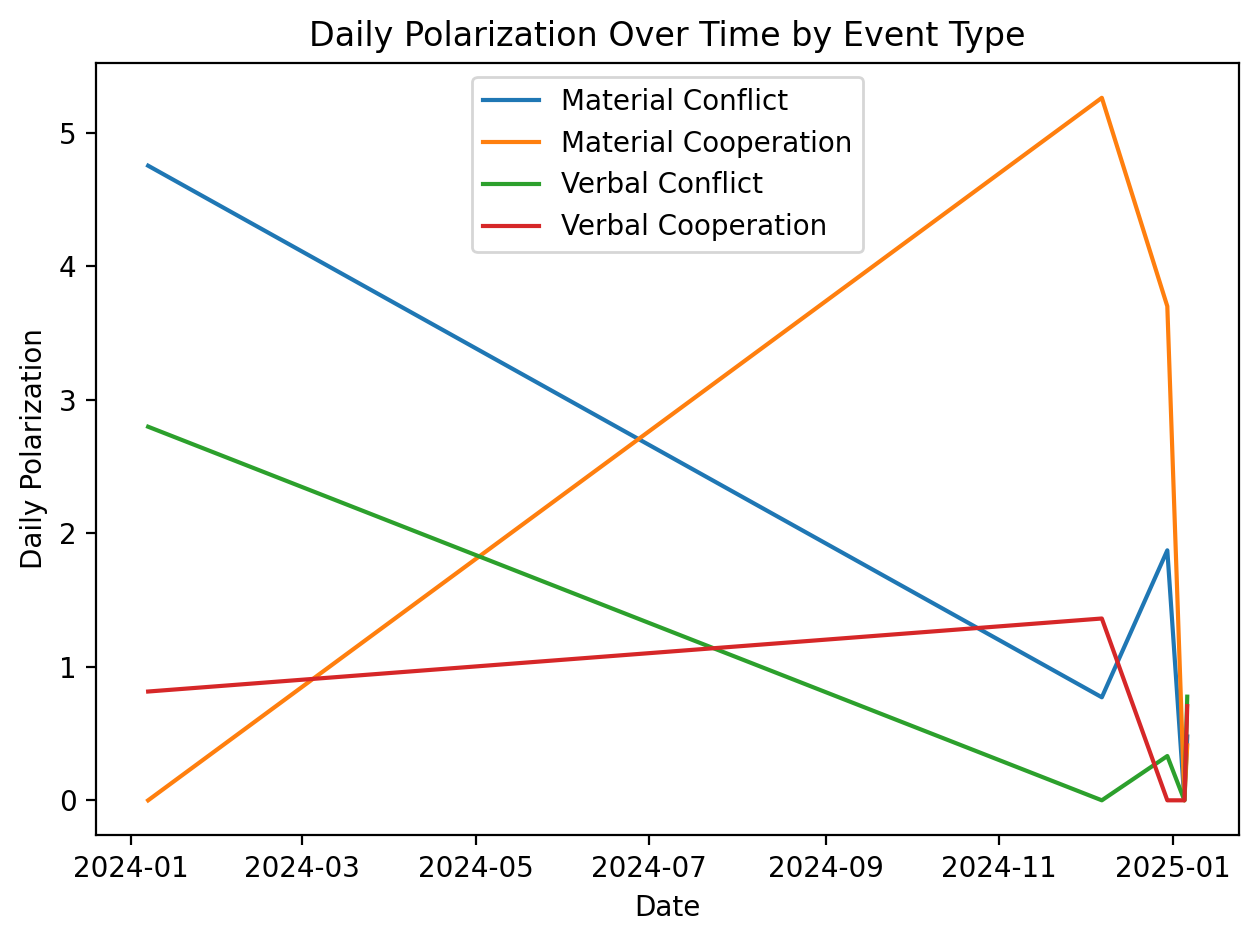

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'with_range' is available in the notebook environment as a Spark DataFrame.
# Convert to Pandas
pdf = with_range.toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])

# Pivot data: index=date, columns=event_type, values=daily_polarization
pivot_df = pdf.pivot(index='date', columns='event_type', values='daily_polarization')

# Plot
plt.figure()
for etype in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[etype], label=etype)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Daily Polarization')
plt.title('Daily Polarization Over Time by Event Type')
plt.tight_layout()
plt.show()


In [31]:
from pyspark.sql.functions import (
    to_date, col, avg, when, broadcast
)

# 1a) Make sure you’ve already got your df2:
#     df2 = df.join(broadcast(region_df), on="source_country", how="inner")

# 1b) Parse your date string into a proper DateType
df_date = df2.withColumn("date", to_date(col("SQLDATE"), "yyyyMMdd"))

# 1c) Define an “entity” column
df_entities = df_date.withColumn("entity",
    when(col("Actor1Name").isin("Israel","ISRAEL") | col("Actor2Name").isin("Israel","ISRAEL"), "Israel")
    .when(col("Actor1Name").isin("Palestinian","PALESTINIAN","Palestine", "Hamas", "HAMAS") 
          | col("Actor2Name").isin("Palestinian","PALESTINIAN","Palestine", "Hamas", "HAMAS"), "Palestinian")
    .otherwise(None)
).filter(col("entity").isNotNull())

# 1d) Compute daily average tone by region & entity
daily_sentiment = (
    df_entities
      .groupBy("date","region","entity")
      .agg(avg(col("AvgTone")).alias("avg_tone"))
      .orderBy("date","region","entity")
)


<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Tone')

Text(0.5, 1.0, 'Sentiment of Israel Coverage by Region')

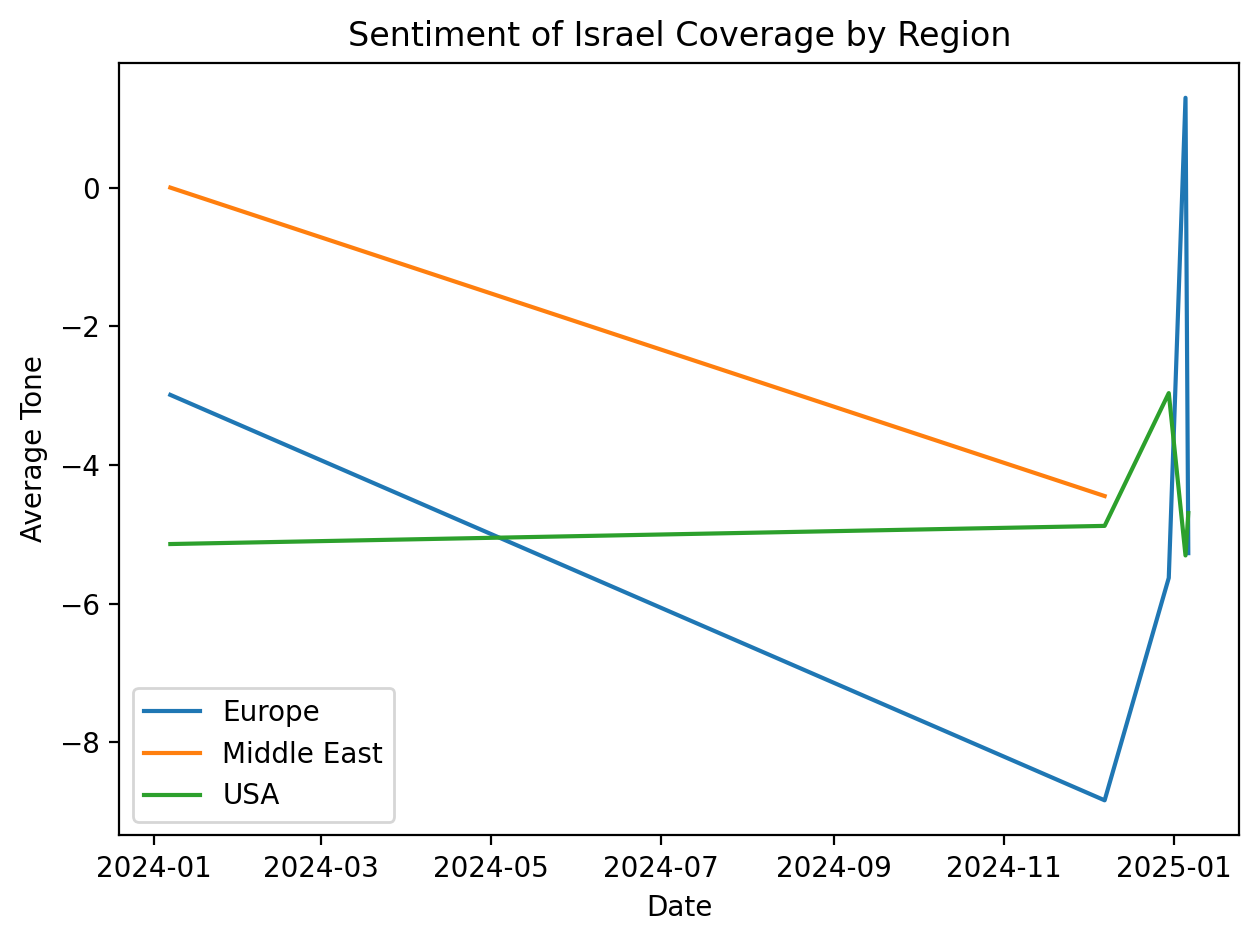

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Average Tone')

Text(0.5, 1.0, 'Sentiment of Palestinian Coverage by Region')

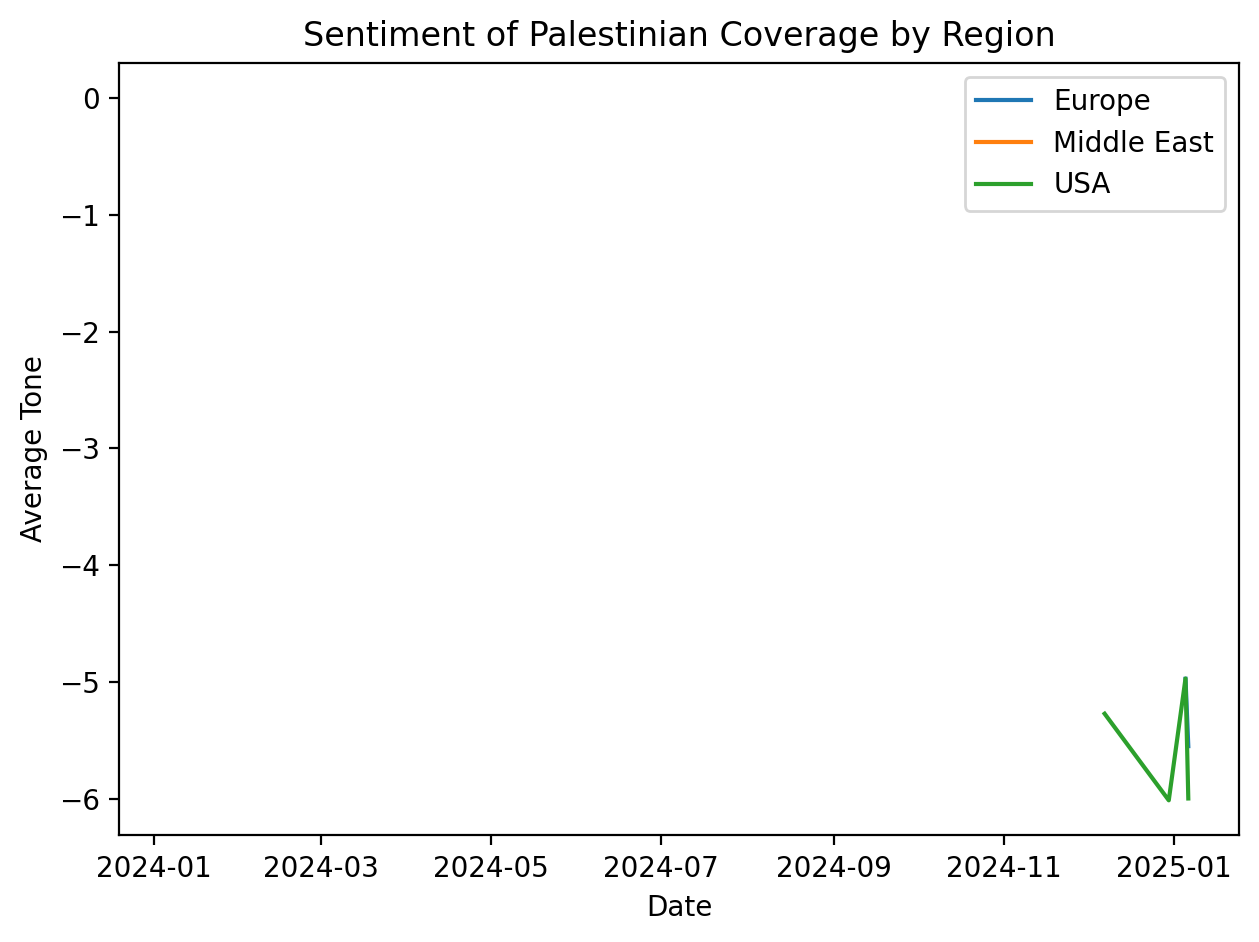

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 2a) Collect to Pandas
pdf = daily_sentiment.toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])

# 2b) Pivot so we have one table per entity:
#     – Israel: index=date, columns=region, values=avg_tone
#     – Palestinian: same
israel_df = pdf[pdf.entity == "Israel"] \
              .pivot(index="date", columns="region", values="avg_tone")
pali_df   = pdf[pdf.entity == "Palestinian"] \
              .pivot(index="date", columns="region", values="avg_tone")

# 2c) Plot Israel coverage
plt.figure()
for region in israel_df.columns:
    plt.plot(israel_df.index, israel_df[region], label=region)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Average Tone")
plt.title("Sentiment of Israel Coverage by Region")
plt.tight_layout()
plt.show()

# 2d) Plot Palestinian coverage
plt.figure()
for region in pali_df.columns:
    plt.plot(pali_df.index, pali_df[region], label=region)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Average Tone")
plt.title("Sentiment of Palestinian Coverage by Region")
plt.tight_layout()
plt.show()
